# What's a causal model?

Neural networks are complex and interesting systems -- yet we have full control over their internals! Interpretability seeks to understand how manipulations of model internals affect their output. The theory of causality, which formalizes causal effects in causal graphs, is fundamental to the field of interpretability.

But what exactly is a causal model? In this tutorial, we walk through a simple causal model with the `CausalAbstraction` library. Along the way, we'll discuss
* The components of causal graphs,
* Operations we can perform on causal graphs,
* and abstractions between causal graphs.

**Note**

For this tutorial, feel free to use CPU-only to save space. This is an introductory tutorial going over causal graphs - we won't be interacting with any neural networks.

📗 Prefer to use Colab? Follow the tutorial [here](https://colab.research.google.com/drive/1olu6jxG4Jt6i4_-7rHUx2apmPw0mkneT)!

## Setup

In [ ]:
# clone causal abstractions library for causal model
import sys
from IPython.display import clear_output

!git clone https://github.com/atticusg/CausalAbstraction.git

sys.path.append('CausalAbstraction')

clear_output()

In [ ]:
# install dash cytoscape for graph visualizations
!pip install dash dash-cytoscape

clear_output()

## Let's set up a causal model

Imagine we trained a neural network to add three numbers, A, B, and C, together. How might it solve this problem?

We can formalize our **hypothesis** as a **causal graph**. The code below sets up a causal graph for an algorithm that adds the three numbers left to right. The causal model first adds A and B together, and then adds C to their sum.

In [ ]:
import random
# we use the CausalAbstraction library to set up a causal model
from causal.causal_model import CausalModel

DIGITS = list(range(0, 10))

######################
# 1. variables       #
######################
# first we specify the variables of our causal model
# A, B, C : the inputs to our model
# A+B : the intermediate operation A + B
# C' : the intermediate value of C (copied from the input)
# Y : the final sum, A + B + C
# raw_input : the raw representation of the inputs (A, B, and C)
# raw_output : the raw representation of the output (Y)
variables = [
    "A", "B", "C",
    "A+B",
    "C\'",
    "Y",
    "raw_input",
    "raw_output"
]

######################
# 2. values          #
######################
# what values can our variables take on?
# let's make the inputs only be single-digit values.
# this means that A + B can be 0-20 (roughly) and
# the answer Y can be 0-30.
values = {
    **{var: DIGITS for var in ['A', 'B', 'C']},
    "A+B": list(range(0, 20)),
    "C\'": DIGITS,
    "Y": list(range(0, 30)),
    "raw_input": None, "raw_output": None
}

######################
# 3. parents         #
######################
# this helps us specify the direction of our causal graph
# A, B, C : no parents, bc they're inputs
# A+B : parents are A and B
# C' : parent is C
# Y : parents are A+B and C' (NOT A, B, or C!)
# raw_input : parents are A, B, and C
# raw_output : parent is Y
parents = {
    "A": [], "B": [], "C": [],
    "A+B": ["A", "B"],
    "C\'": ["C"],
    "Y": ["A+B", "C\'"],
    "raw_input": ["A", "B", "C"],
    "raw_output": ["Y"]
}

######################
# 4. mechanisms      #
######################
# HOW do the variables affect each other?
# A, B, C : provide default values
# A+B : computes A + B
# C' : copies over the value of C
# Y : computes A+B + C' (NOTE: we're using the intermediate variables!)
# raw_input : represents A+B+C as a list
# raw_output : represents Y as an int
mechanisms = {
    "A": lambda: random.choice(DIGITS),
    "B": lambda: random.choice(DIGITS),
    "C": lambda: random.choice(DIGITS),
    "A+B": lambda a, b: (a + b),
    "C\'": lambda c: c,
    "Y": lambda a_plus_b, c_: (a_plus_b + c_),
    "raw_input": lambda a, b, c: [a, b, c],
    "raw_output": lambda y: y
}

# put it all together!
causal_model = CausalModel(variables, values, parents, mechanisms, id="Hierarchical addition")

Let's visualize our causal graph. The arrows show which variables have a direct causal effect on each other. If we can take a path from variable $\alpha$ to variable $\beta$, then we can say that $\alpha$ _has a causal effect on_ $\beta$. That is, changing the value of $\alpha$ may change the value of $\beta$.

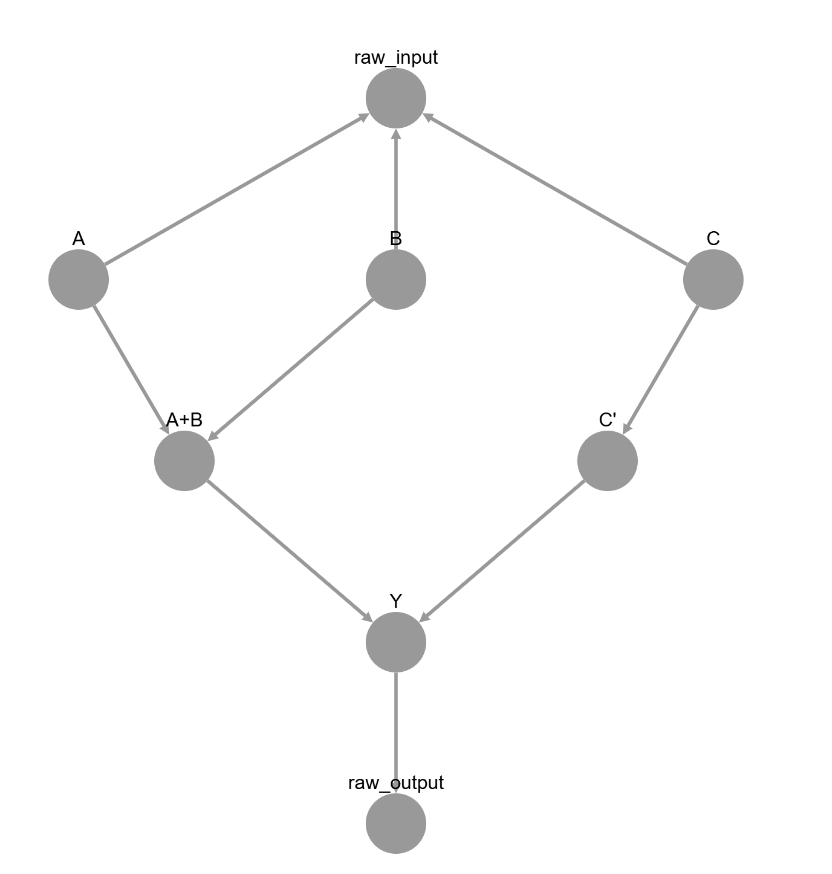

In [ ]:
causal_model.display_structure()

We can pass inputs into our causal model and **run it "forward"** to simulate the algorithm's final output - as well as its intermediate values.

In our visualization, we represent inputs as dark teal nodes, and the intermediate/output values as light teal nodes.

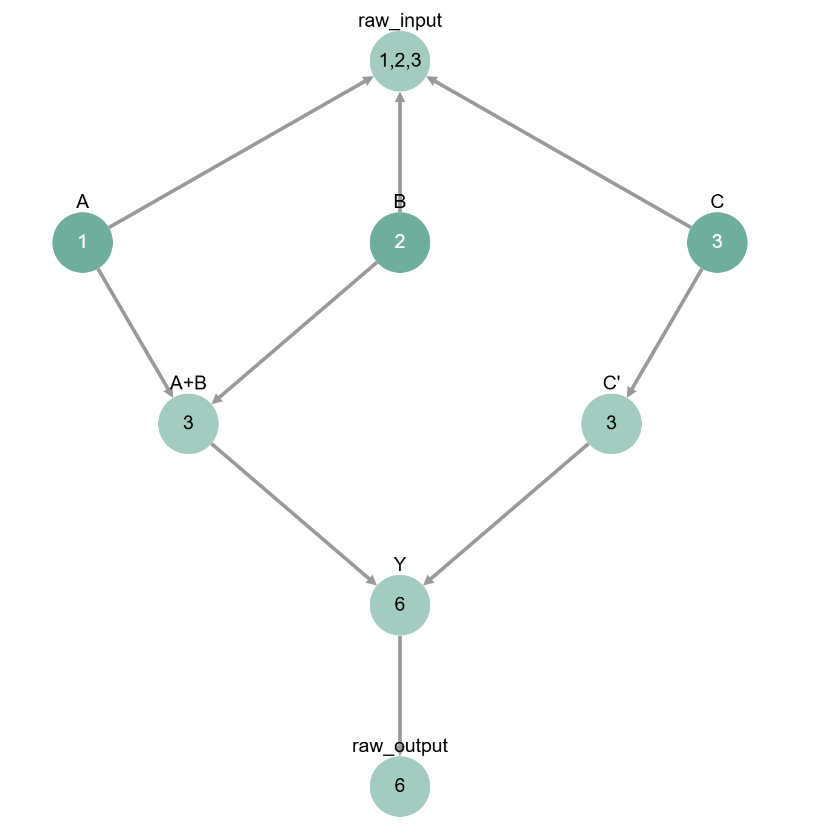

In [ ]:
# play around with different inputs!
inputs = {'A': 1, 'B': 2, 'C': 3}

causal_model.display_forward_pass(inputs)

We can represent any causal process in a causal graph - including neural networks!

In [ ]:
# don't feel like you need to understand this code just yet!
# the important point is that we can visualize neural networks just like causal graphs
import torch

l1 = torch.nn.Linear(3, 3)
l2 = torch.nn.Linear(3, 3)
l3 = torch.nn.Linear(3, 1)

variables = [
    'A', 'B', 'C',
    *[f'h1{i+1}' for i in range(3)],
    *[f'h2{i+1}' for i in range(3)],
    'h31',
    'raw_input',
    'raw_output'
]

values = {var: None for var in variables}

parents = {
    'A': [], 'B': [], 'C': [],
    **{f'h1{i+1}': ['A', 'B', 'C'] for i in range(3)},
    **{f'h2{i+1}': ['h11', 'h12', 'h13'] for i in range(3)},
    'h31': ['h21', 'h22', 'h23'],
    "raw_input": ["A", "B", "C"],
    "raw_output": ["h31"]
}

mechanisms = {
    **{f'h1{i+1}': lambda a, b, c: l1(torch.FloatTensor([a, b, c])).round()[i].item() for i in range(3)},
    **{f'h2{i+1}': lambda h11, h12, h13: l2(torch.FloatTensor([h11, h12, h13])).round()[i].item() for i in range(3)},
    'h31': lambda h21, h22, h23: l3(torch.FloatTensor([h21, h22, h23])).round().item(),
    "A": lambda: random.choice(DIGITS),
    "B": lambda: random.choice(DIGITS),
    "C": lambda: random.choice(DIGITS),
    "raw_input": lambda a, b, c: [a, b, c],
    "raw_output": lambda y: y
}

neural_network = CausalModel(variables, values, parents, mechanisms, id="Hierarchical addition")

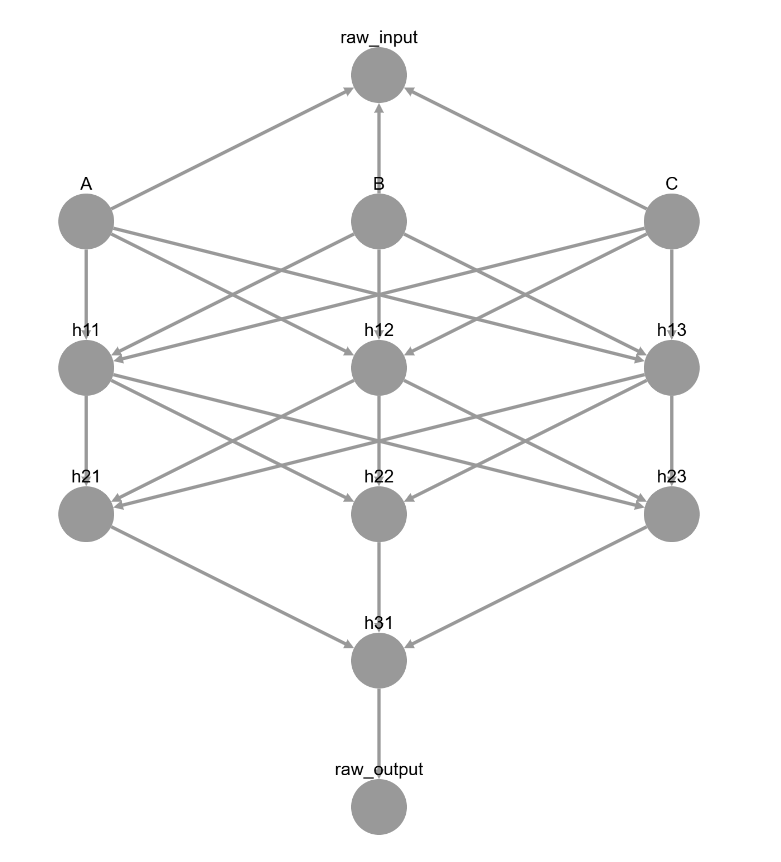

In [ ]:
neural_network.display_structure()

Keep this in mind - we'll come back to the idea of representing neural networks as causal models soon! For now, let's see what we can actually do with a causal graph.

## Operations on causal graphs

Now that we know what a causal model looks like, let's try playing around with it. The key operation we can perform on a causal graph is an **intervention**. When we perform an intervention, we **change the value of a variable** - this might have downstream effects on the model's computation.

### Intervening on a causal graph

For example, what if the model thought that 1 + 2 was actually 4 instead of 3?

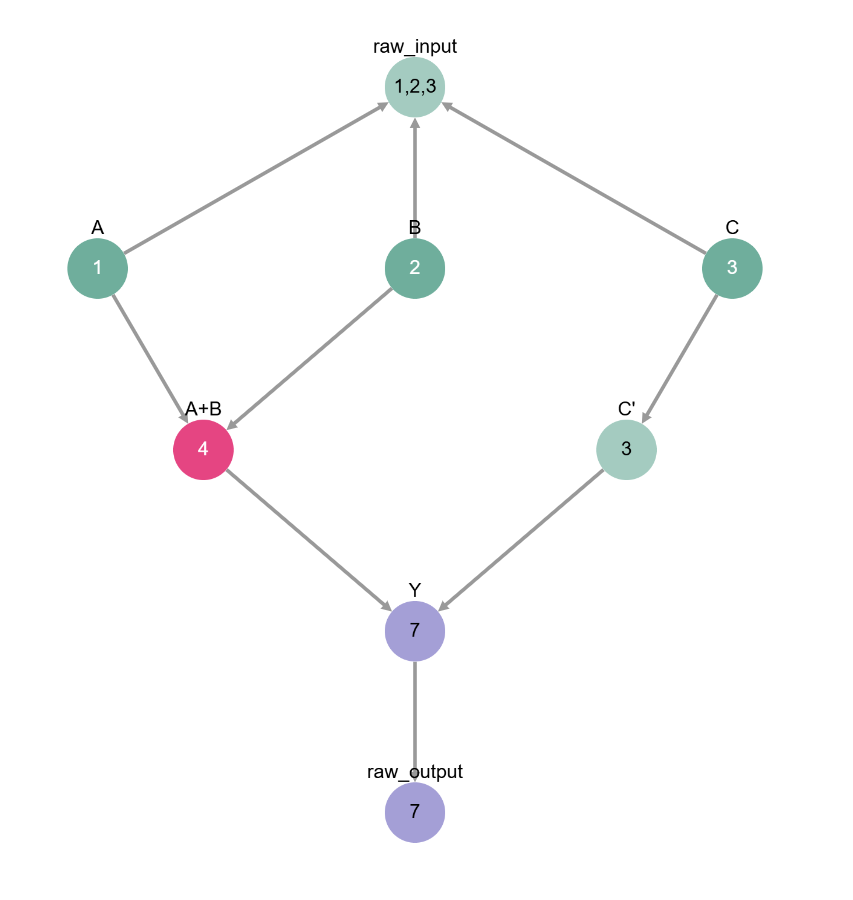

In [ ]:
inputs = {'A': 1, 'B': 2, 'C': 3}
# let's make the model think that 1 + 2 is 4!
intervention = {'A+B': 4}

# we "run the model forward" again,
# but this time with an intervention changing A + B to 4
causal_model.display_forward_pass(inputs, intervention=intervention)

As you might have predicted, the causal model's new answer is 7 instead of 6.

*Visualization note: We color the intervention in dark magenta and the values it affects in either light magenta (if the intervention directly affected the value) or violet (if the value was caused by a mix of intervened and base values).*

We can choose any variable to intervene on! For example, we can intervene directly on the output.

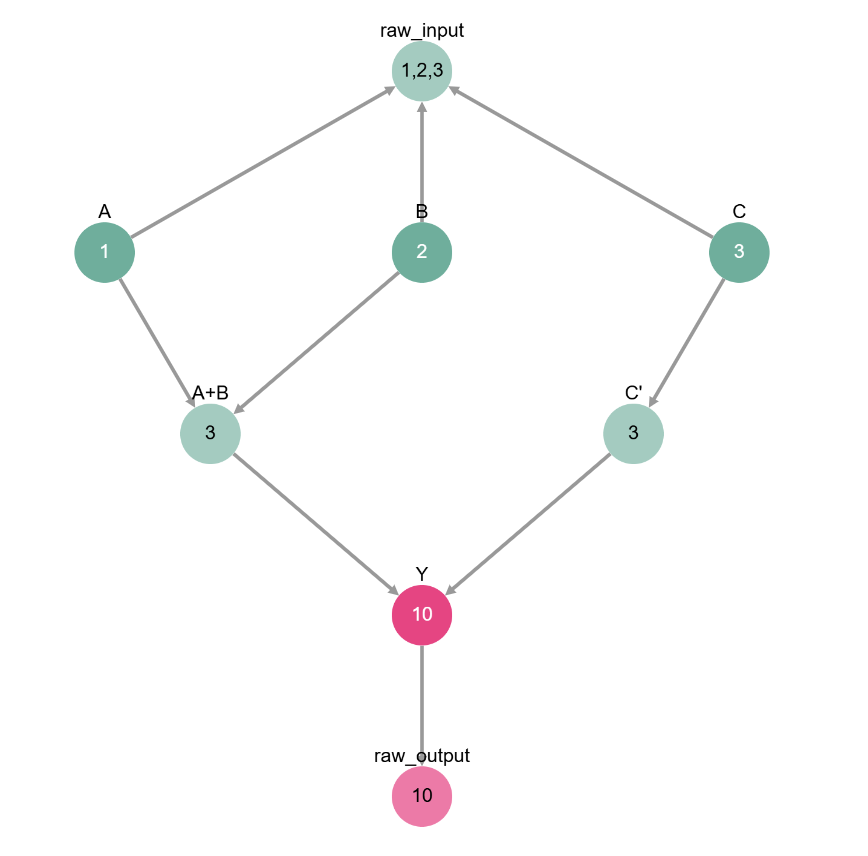

In [ ]:
inputs = {'A': 1, 'B': 2, 'C': 3}
# let's make the model think that the answer is 10
intervention = {'Y': 10}

causal_model.display_forward_pass(inputs, intervention=intervention)

*Visualization note: since the `raw_output` only depends on the value of the intervened variable (and not the base inputs) we color it in magenta instead of violet.*

We can also intervene on parts of the input. For example, let's change just the value of the variable `C` in the input.

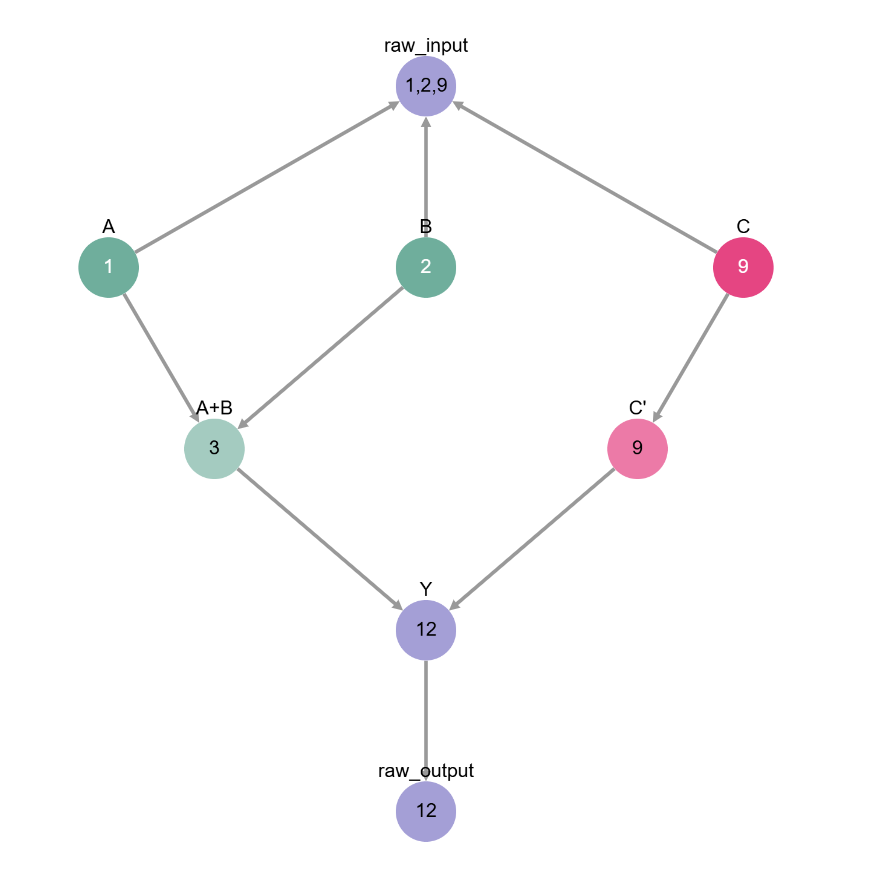

In [ ]:
inputs = {'A': 1, 'B': 2, 'C': 3}
# let's replace the input C with 9
intervention = {'C': 9}

causal_model.display_forward_pass(inputs, intervention=intervention)

Of course, we could've simulated the model's output by just plugging in 9 for C. But the causal model still plays an important role here - it predicts what each intermediate value will turn out!

We can also intervene on multiple variables at the same time. For example, let's see what happens when we set `A + B` to 8 and `C'` to 4.

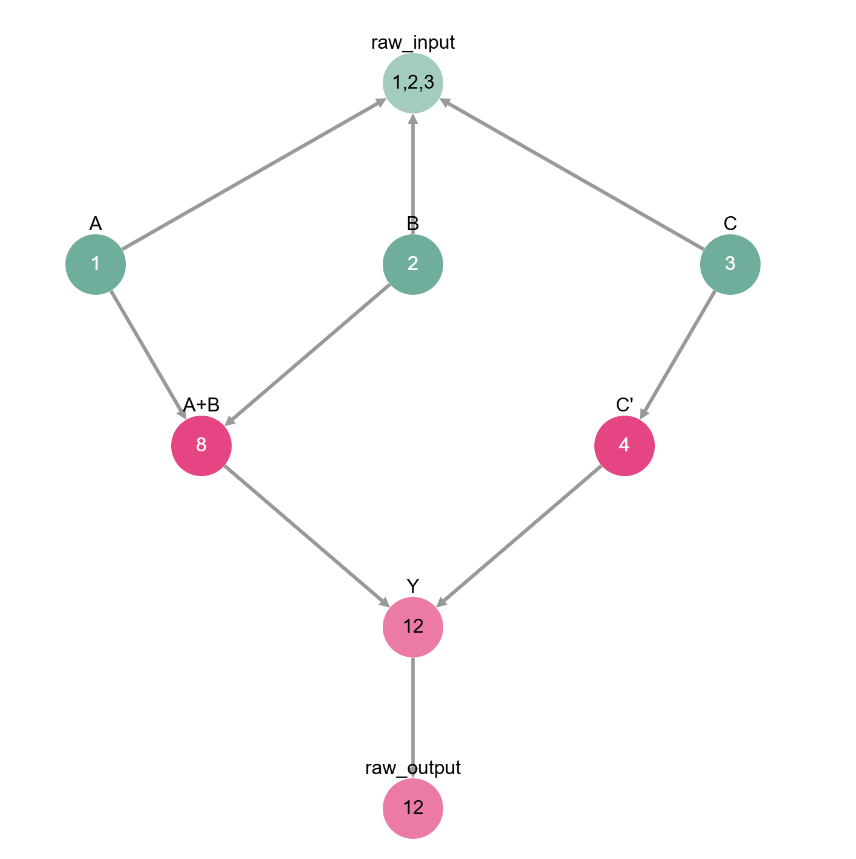

In [ ]:
inputs = {'A': 1, 'B': 2, 'C': 3}
# let's intervene on all of the intermediate variables
intervention = {'A+B': 8, 'C\'': 4}

causal_model.display_forward_pass(inputs, intervention=intervention)

At this point, we overrode the effects of the inputs! Nevertheless, we have a prediction of what the final output will be, given our interventions.

### Interchange interventions

Interventions are powerful when we know the intermediate values of our causal model. However, in the case of complex systems such as neural networks, the intermediate values might not be predictable or interpretable. For example, it's hard to predict a reasonable value for an MLP activation.

A very powerful operation we can perform on causal models is an **interchange intervention**. In an interchange intervention, we **don't specify intermediate *values***. Instead, we choose a **set of inputs for the variable we want to change**, and let the causal model **infer** the intermediate value from those causal variables.

For example, let's change the model to think that `A + B` is 4 again. This time, we won't specify 4 up front. Instead, we'll **get the value for `A + B`** from running a **separate forward pass** on the inputs `A = 3` and `B = 1`.

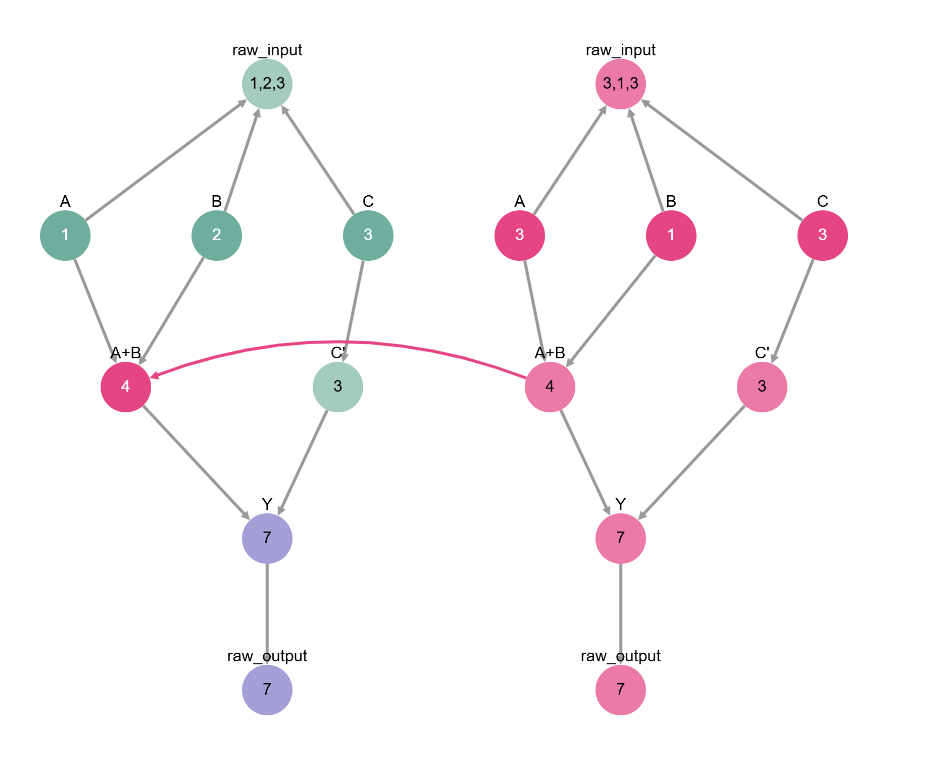

In [ ]:
inputs = {'A': 1, 'B': 2, 'C': 3}

# let's change the value of A + B to be 3 + 1!
counterfactual_inputs = {
    'A+B': {'A': 3, 'B': 1, 'C': 3},
}

causal_model.display_interchange(inputs, counterfactual_inputs)

The result is the same as intervening on `A + B` directly and setting it to 4. But this time around, we didn't need to "magically" come up with the number 4 - instead, it came from the model's evaluation on a separate set of inputs. By **interchanging** the value of a variable across two separate forward passes of our causal model, we can estimate its **counterfactual behavior** when we edit the value of one of its variables.

*Side note: just like with interventions, we can perform an interchange intervention on multiple variables! For each variable, we can specify a different source input that will specify its value.*

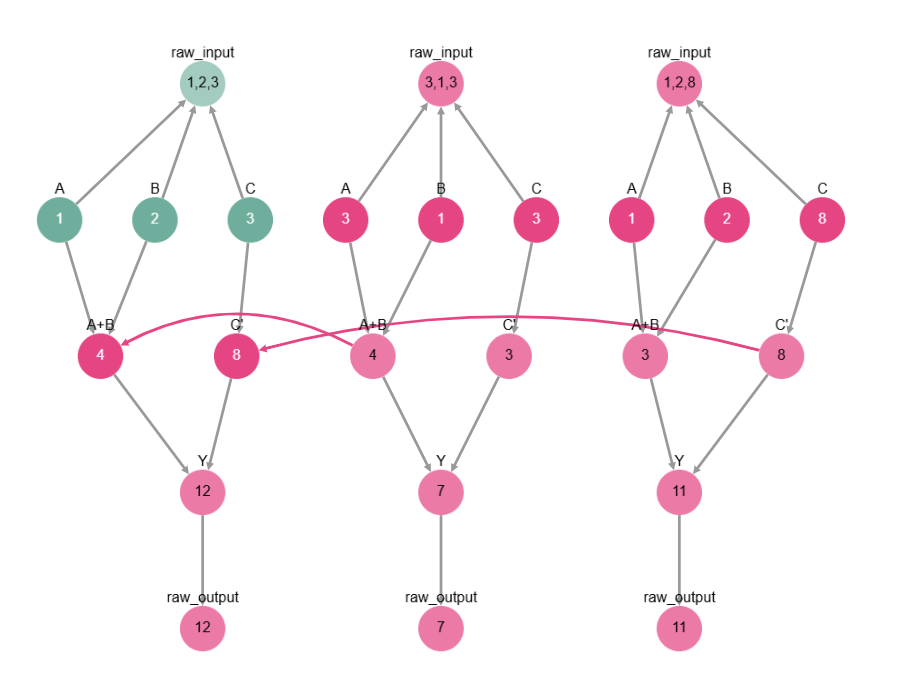

In [ ]:
inputs = {'A': 1, 'B': 2, 'C': 3}

# let's change the value of A + B and C' using different sources
counterfactual_inputs = {
    'A+B': {'A': 3, 'B': 1, 'C': 3}, # make A + B = 3 + 1
    'C\'': {'A': 1, 'B': 2, 'C': 8}, # make C' = 8
}

causal_model.display_interchange(inputs, counterfactual_inputs)